In [9]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report

# Load the file
df = pd.read_csv("synthetic_network_traffic.csv")


In [10]:
#Feature Engineering
df['TotalBytes'] = df['BytesSent'] + df['BytesReceived']
df['TotalPackets'] = df['PacketsSent'] + df['PacketsReceived']

#  Define features and target
X = df.drop(columns=['IsAnomaly'])
y = df['IsAnomaly']

# Handle imbalance using SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_resampled)

# Split into train-test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)


In [11]:
# Train Isolation Forest with optimized settings
isolation_forest = IsolationForest(contamination=0.01, random_state=42)
isolation_forest.fit(X_train)


IsolationForest(contamination=0.01, random_state=42)

In [12]:
# Train Random Forest
rf = RandomForestClassifier(n_estimators=50, max_depth=10, n_jobs=-1, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

In [13]:
# Custom thresholding based on anomaly scores
scores = isolation_forest.decision_function(X_test)
threshold = np.percentile(scores, 5)
y_pred_if = np.where(scores < threshold, 1, 0)  # 1 = anomaly

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_if)
tn, fp, fn, tp = cm.ravel()

# Compute metrics per class
precision_0 = tn / (tn + fp)
recall_0 = tn / (tn + fn)
specificity_0 = tn / (tn + fp)
f1_0 = 2 * precision_0 * recall_0 / (precision_0 + recall_0)

precision_1 = tp / (tp + fp) if (tp + fp) > 0 else 0
recall_1 = tp / (tp + fn) if (tp + fn) > 0 else 0
specificity_1 = tp / (tp + fn) if (tp + fn) > 0 else 0
f1_1 = 2 * precision_1 * recall_1 / (precision_1 + recall_1) if (precision_1 + recall_1) > 0 else 0

# Support counts
support_0 = tn + fp
support_1 = tp + fn

# Accuracy
accuracy = accuracy_score(y_test, y_pred_if)

# Macro and weighted averages
report_df = pd.DataFrame([
    ["Normal (0)", precision_0, recall_0, specificity_0, f1_0, support_0],
    ["Anomaly (1)", precision_1, recall_1, specificity_1, f1_1, support_1]
], columns=["Class", "precision", "recall", "Specificity", "f1-score", "support"]).round(2)

macro_avg = report_df[["precision", "recall", "Specificity", "f1-score"]].mean().round(2)
weighted_avg = (
    report_df[["precision", "recall", "Specificity", "f1-score"]]
    .multiply(report_df["support"], axis=0)
    .sum() / report_df["support"].sum()
).round(2)

# Summary section
summary_data = [
    ["accuracy", round(accuracy, 2), "", "", "", support_0 + support_1],
    ["macro avg", *macro_avg.tolist(), support_0 + support_1],
    ["weighted avg", *weighted_avg.tolist(), support_0 + support_1]
]

columns = ["Class", "precision", "recall", "Specificity", "f1-score", "support"]
summary_df = pd.DataFrame(summary_data, columns=columns)

# Combine and show report
final_report = pd.concat([report_df, summary_df], ignore_index=True)
print("=== Isolation Forest Evaluation ===")
print(final_report.to_string(index=False))


=== Isolation Forest Evaluation ===
       Class  precision recall Specificity f1-score  support
  Normal (0)       0.93   0.49        0.93     0.64   199000
 Anomaly (1)       0.28   0.03        0.03     0.05   199000
    accuracy       0.48                               398000
   macro avg       0.60   0.26        0.48     0.34   398000
weighted avg       0.60   0.26        0.48     0.34   398000


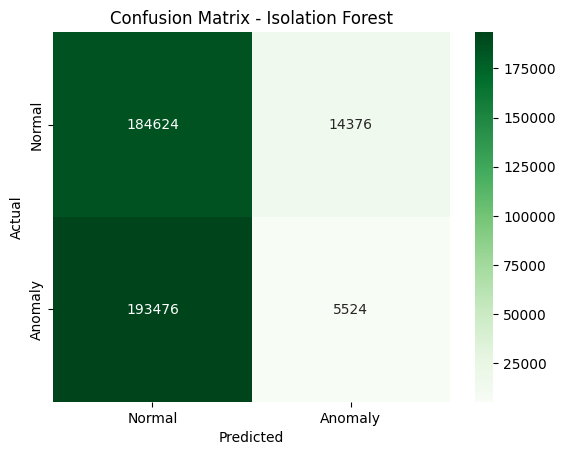

In [14]:
# Confusion Matrix for Isolation Forest
cm_if = confusion_matrix(y_test, y_pred_if)
tn_if, fp_if, fn_if, tp_if = cm_if.ravel()
if_specificity = tn_if / (tn_if + fp_if)
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens", xticklabels=["Normal", "Anomaly"], yticklabels=["Normal", "Anomaly"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Isolation Forest")
plt.show()


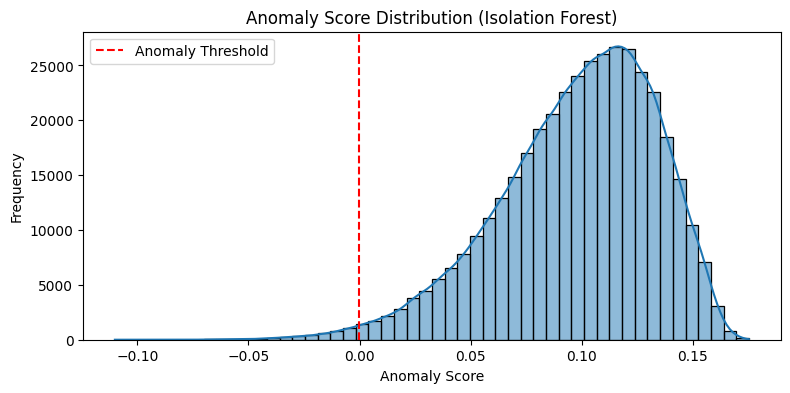

In [15]:
#Histogram for Anomaly Score Distribution Using Isolation Forest
scores = isolation_forest.decision_function(X_test)

plt.figure(figsize=(9, 4))
sns.histplot(scores, bins=50, kde=True)
plt.axvline(np.percentile(scores, 1), color='red', linestyle='--', label='Anomaly Threshold')
plt.title("Anomaly Score Distribution (Isolation Forest)")
plt.xlabel("Anomaly Score")
plt.ylabel("Frequency")
plt.legend()
plt.show()


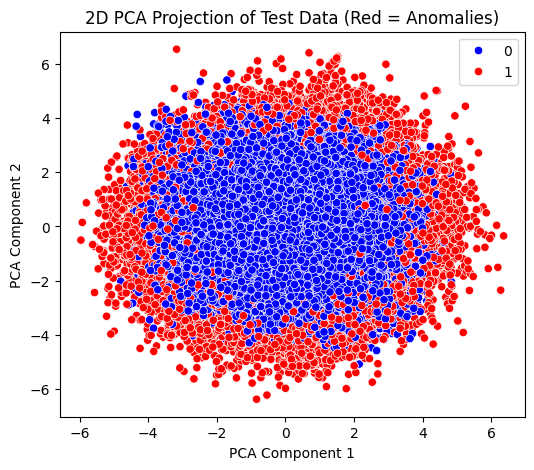

In [17]:
from sklearn.decomposition import PCA

# 2D PCA-Based Visualization of Isolation Forest Predictions (Red = Anomalies)
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X_test)

plt.figure(figsize=(6, 5))
sns.scatterplot(x=X_2d[:, 0], y=X_2d[:, 1], hue=y_pred_if, palette={0: 'blue', 1: 'red'}, legend='full')
plt.title("2D PCA Projection of Test Data (Red = Anomalies)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()


In [18]:
# Use fewer estimators
rf = RandomForestClassifier(n_estimators=50, max_depth=10, n_jobs=-1, random_state=42)
rf.fit(X_train, y_train)

# Predict and evaluate
y_pred_rf = rf.predict(X_test)

print("=== Random Forest Classification Report ===")
print(classification_report(y_test, y_pred_rf))


=== Random Forest Classification Report ===
              precision    recall  f1-score   support

           0       0.72      0.44      0.54    199000
           1       0.60      0.83      0.70    199000

    accuracy                           0.63    398000
   macro avg       0.66      0.63      0.62    398000
weighted avg       0.66      0.63      0.62    398000



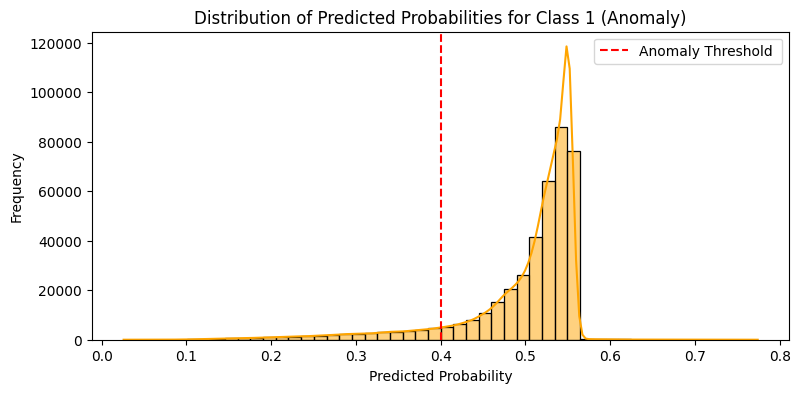

In [48]:
# Get predicted probabilities for Class 1 (Anomaly)
rf_probs = rf.predict_proba(X_test)[:, 1]  # Probabilities for class 1

# Plot the distribution of predicted probabilities
plt.figure(figsize=(9, 4))
sns.histplot(rf_probs, bins=50, kde=True, color="orange")

# Show only the custom threshold
plt.axvline(0.4, color='red', linestyle='--', label='Anomaly Threshold ')

plt.title("Distribution of Predicted Probabilities for Class 1 (Anomaly)")
plt.xlabel("Predicted Probability")
plt.ylabel("Frequency")
plt.legend()
plt.show()


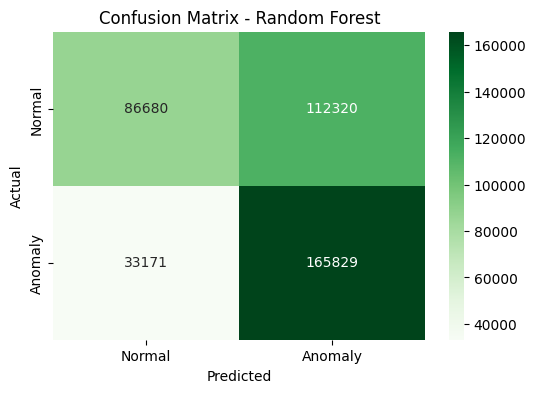

In [19]:
# Confusion Matrix for Random Forest
cm_rf = confusion_matrix(y_test, y_pred_rf)
tn_rf, fp_rf, fn_rf, tp_rf = cm_rf.ravel()
plt.figure(figsize=(6, 4))
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Greens", xticklabels=["Normal", "Anomaly"], yticklabels=["Normal", "Anomaly"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Random Forest")
plt.show()

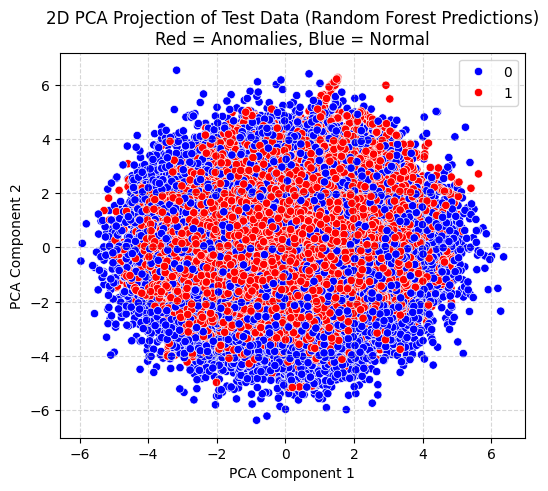

In [43]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Perform PCA on the test set
pca = PCA(n_components=2)
X_test_pca = pca.fit_transform(X_test)

# Visualize predictions from Random Forest
plt.figure(figsize=(6, 5))
sns.scatterplot(x=X_test_pca[:, 0], y=X_test_pca[:, 1],
                hue=y_pred_rf, palette={0: 'blue', 1: 'red'}, legend='full')
plt.title("2D PCA Projection of Test Data (Random Forest Predictions)\nRed = Anomalies, Blue = Normal")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

In [49]:
import pandas as pd
from sklearn.metrics import confusion_matrix, accuracy_score

# Confusion matrices
cm_if = confusion_matrix(y_test, y_pred_if)
cm_rf = confusion_matrix(y_test, y_pred_rf)
tn_if, fp_if, fn_if, tp_if = cm_if.ravel()
tn_rf, fp_rf, fn_rf, tp_rf = cm_rf.ravel()

# Accuracy
acc_if = accuracy_score(y_test, y_pred_if)
acc_rf = accuracy_score(y_test, y_pred_rf)

# Function to compute class-wise metrics
def metrics_by_class(tn, fp, fn, tp, acc):
    return {
        "Accuracy": acc,
        "Precision_0": tn / (tn + fp),
        "Recall_0": tn / (tn + fn),
        "Specificity_0": tn / (tn + fp),
        "F1_0": 2 * (tn / (tn + fp)) * (tn / (tn + fn)) / ((tn / (tn + fp)) + (tn / (tn + fn))),
        "Precision_1": tp / (tp + fp) if (tp + fp) > 0 else 0,
        "Recall_1": tp / (tp + fn) if (tp + fn) > 0 else 0,
        "Specificity_1": tp / (tp + fn) if (tp + fn) > 0 else 0,
        "F1_1": 2 * (tp / (tp + fp)) * (tp / (tp + fn)) / ((tp / (tp + fp)) + (tp / (tp + fn)))
        if (tp + fp) > 0 and (tp + fn) > 0 else 0
    }

# Compute metrics
metrics_if = metrics_by_class(tn_if, fp_if, fn_if, tp_if, acc_if)
metrics_rf = metrics_by_class(tn_rf, fp_rf, fn_rf, tp_rf, acc_rf)

# Create DataFrame
summary_df = pd.DataFrame([metrics_if, metrics_rf], index=["Isolation Forest", "Random Forest"]).round(2)

# Reorder and rename columns for clarity
summary_df = summary_df[[
    "Accuracy",
    "Precision_0", "Recall_0", "Specificity_0", "F1_0",
    "Precision_1", "Recall_1", "Specificity_1", "F1_1"
]].rename(columns={
    "Precision_0": "Precision 0",
    "Precision_1": "Precision 1",
    "Recall_0": "Recall 0",
    "Recall_1": "Recall 1",
    "Specificity_0": "Specificity 0",
    "Specificity_1": "Specificity 1",
    "F1_0": "F1-Score 0",
    "F1_1": "F1-Score 1"
})

# Display
from IPython.display import display
display(summary_df.style.highlight_max(subset=["Accuracy"], color='lightgreen').format("{:.2f}"))


,Accuracy,Precision 0,Recall 0,Specificity 0,F1-Score 0,Precision 1,Recall 1,Specificity 1,F1-Score 1
Isolation Forest,0.48,0.93,0.49,0.93,0.64,0.28,0.03,0.03,0.05
Random Forest,0.63,0.44,0.72,0.44,0.54,0.60,0.83,0.83,0.70


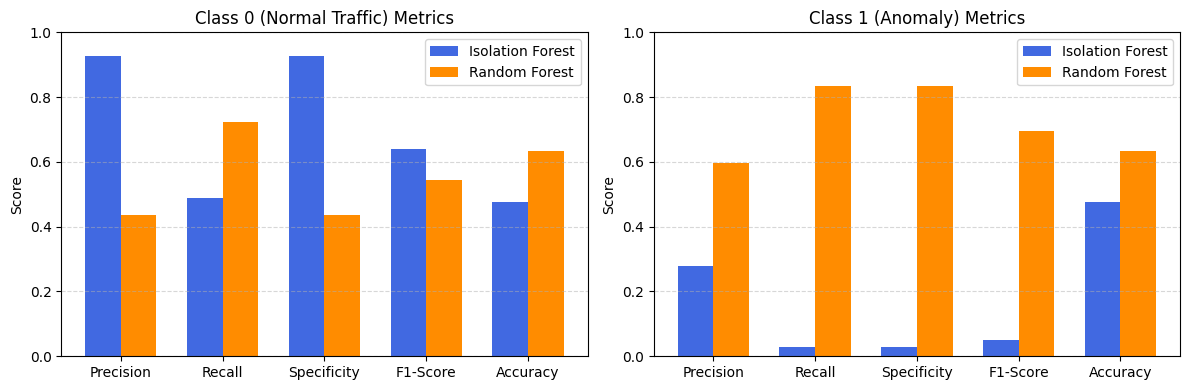

In [26]:
# Confusion matrices
cm_if = confusion_matrix(y_test, y_pred_if)
cm_rf = confusion_matrix(y_test, y_pred_rf)
tn_if, fp_if, fn_if, tp_if = cm_if.ravel()
tn_rf, fp_rf, fn_rf, tp_rf = cm_rf.ravel()

# Accuracy
acc_if = accuracy_score(y_test, y_pred_if)
acc_rf = accuracy_score(y_test, y_pred_rf)

# Function to compute metrics
def calculate_metrics(tn, fp, fn, tp, accuracy):
    precision_0 = tn / (tn + fp)
    recall_0 = tn / (tn + fn)
    specificity_0 = tn / (tn + fp)
    f1_0 = 2 * precision_0 * recall_0 / (precision_0 + recall_0)

    precision_1 = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall_1 = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity_1 = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1_1 = 2 * precision_1 * recall_1 / (precision_1 + recall_1) if (precision_1 + recall_1) > 0 else 0

    return {
        "Class 0": [precision_0, recall_0, specificity_0, f1_0, accuracy],
        "Class 1": [precision_1, recall_1, specificity_1, f1_1, accuracy]
    }

# Get metrics
metrics_if = calculate_metrics(tn_if, fp_if, fn_if, tp_if, acc_if)
metrics_rf = calculate_metrics(tn_rf, fp_rf, fn_rf, tp_rf, acc_rf)

# Labels
metrics_labels = ["Precision", "Recall", "Specificity", "F1-Score", "Accuracy"]

# Convert for plotting
class0_if = metrics_if["Class 0"]
class0_rf = metrics_rf["Class 0"]
class1_if = metrics_if["Class 1"]
class1_rf = metrics_rf["Class 1"]

# Plotting
x = np.arange(len(metrics_labels))
width = 0.35

plt.figure(figsize=(12, 4))

# Class 0 plot
plt.subplot(1, 2, 1)
plt.bar(x - width/2, class0_if, width, label="Isolation Forest", color='royalblue')
plt.bar(x + width/2, class0_rf, width, label="Random Forest", color='darkorange')
plt.xticks(x, metrics_labels)
plt.ylim(0, 1)
plt.ylabel("Score")
plt.title("Class 0 (Normal Traffic) Metrics")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.legend()

# Class 1 plot
plt.subplot(1, 2, 2)
plt.bar(x - width/2, class1_if, width, label="Isolation Forest", color='royalblue')
plt.bar(x + width/2, class1_rf, width, label="Random Forest", color='darkorange')
plt.xticks(x, metrics_labels)
plt.ylim(0, 1)
plt.ylabel("Score")
plt.title("Class 1 (Anomaly) Metrics")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.legend()

plt.tight_layout()
plt.show()

In [32]:
# Make final predictions using the best model (Random Forest)
final_predictions = rf.predict(X_test)

# Convert predictions to a DataFrame for inspection or export
prediction_results = pd.DataFrame({
    "Actual": y_test,
    "Predicted": final_predictions
}).reset_index(drop=True)

# Show the first few rows of the results
print("=== Final Predictions from Best Model (Random Forest) ===")
prediction_results.head()


=== Final Predictions from Best Model (Random Forest) ===


,Actual,Predicted
0,0,1
1,1,0
2,1,1
3,0,1
4,1,1


In [37]:
# Get predicted probabilities for Class 1 (Anomaly) for all test samples
proba_rf = rf.predict_proba(X_test)[:, 1]  # All class 1 probabilities
# Check probability for sample at index 1
print(f"Predicted probability for Class 1 (Anomaly) at index 1: {proba_rf[1]:.2f}")
print(f"Actual class: {y_test.iloc[1]}")
print(f"Predicted class: {final_predictions[1]}")


Predicted probability for Class 1 (Anomaly) at index 1: 0.50
Actual class: 1
Predicted class: 0


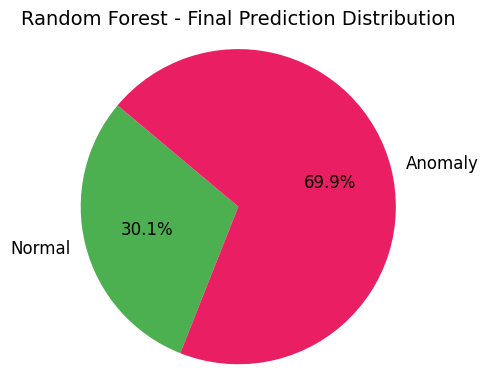

In [69]:
import matplotlib.pyplot as plt
import pandas as pd

# Count predictions (assuming final_predictions is already defined)
labels = ["Normal", "Anomaly"]
counts = pd.Series(final_predictions).value_counts().sort_index()

# Custom colors (fresh and presentation-friendly)
colors = ['#4CAF50', '#E91E63']  # Green for Normal, Pink/Red for Anomaly

# Plot
plt.figure(figsize=(5, 4))
plt.pie(counts, labels=labels, autopct='%1.1f%%', colors=colors, startangle=140,
        textprops={'fontsize': 12})
plt.title("Random Forest - Final Prediction Distribution", fontsize=14)
plt.axis('equal')  # Ensures pie is perfectly circular
plt.tight_layout()
plt.show()
